In [1]:
import sys, os
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent)) # add parent directory to path to import python files from there
import pickle


from cellpose import models
import segmentation_helper
import data_loader
import plotting
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

from cellpose import models


In [3]:
do_inference = False
Tar_path = 'F:/cellpose/tsne/preds'
os.makedirs(Tar_path, exist_ok=True)

if do_inference == True:
    model = models.CellposeModel(gpu=True,pretrained_model='F:/git/grain_seg_ml/models/full_set.060223')
    im_paths = ['F:/cellpose/full_set/train', 'F:/cellpose/full_set/test']
    res=[segmentation_helper.predict_folder(im_paths[i],model,min_size=-1,TAR_DIR=Tar_path,return_results=True) for i in range(len(im_paths))]

    with open('res_train_tSNE.pkl', 'wb') as handle:
        pickle.dump(res[0][2], handle)
    
    with open('res_test_tSNE.pkl', 'wb') as handle:
        pickle.dump(res[1][2], handle)

else:
    pkl_file = open('res_train_tSNE.pkl', 'rb')
    tres = pickle.load(pkl_file)
    train_styles = tres[2]
    trainnames = tres[3]
    pkl_file.close()

    pkl_file = open('res_test_tSNE.pkl', 'rb')
    ttres = pickle.load(pkl_file)
    test_styles = ttres[2]
    testnames = ttres[3]
    pkl_file.close()

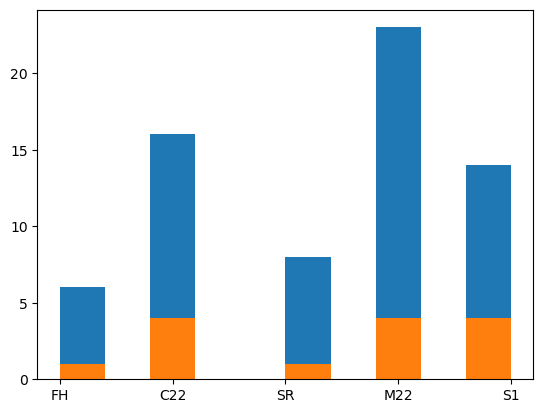

In [27]:
# Check for different data sources
classes = ['C22','M22','FH','SR','S1']
C22_keys = ['kanaka','DS8','deer','hidden']
M22_keys = ['L2','K1','S9']
S1_keys = ['S1']
FH_keys = ['P106']
SR_keys = ['GU','Luet','Rhein','Simme','Thur']
data_classes_train = []
for idx in range(len(trainnames)):
    if any (x in trainnames[idx] for x in C22_keys):
        cl_name='C22'
    elif any (x in trainnames[idx] for x in M22_keys):
        cl_name='M22'
    elif any (x in trainnames[idx] for x in S1_keys):
        cl_name='S1'
    elif any (x in trainnames[idx] for x in FH_keys):
        cl_name='FH'
    elif any (x in trainnames[idx] for x in SR_keys):
        cl_name='SR'
    else:
        cl_name='unknown'
    data_classes_train.append(cl_name)
plt.hist(data_classes_train);

data_classes_test = []
for idx in range(len(testnames)):
    if any (x in testnames[idx] for x in C22_keys):
        cl_name='C22'
    elif any (x in testnames[idx] for x in M22_keys):
        cl_name='M22'
    elif any (x in testnames[idx] for x in S1_keys):
        cl_name='S1'
    elif any (x in testnames[idx] for x in FH_keys):
        cl_name='FH'
    elif any (x in testnames[idx] for x in SR_keys):
        cl_name='SR'
    else:
        cl_name='unknown'
    data_classes_test.append(cl_name)
plt.hist(data_classes_test);

In [7]:
aData = pd.DataFrame(train_styles)
aData.shape

(67, 256)

In [8]:
from scipy.sparse import csc_matrix
sparseMatrix = csc_matrix(train_styles, 
                          dtype = np.float32).toarray()
print(sparseMatrix.shape)
adata=sc.AnnData(sparseMatrix)
adata.obs_names= trainnames
adata.obs["class"]=data_classes_train
print(adata)
print(adata.obs_names[:10])

(67, 256)
AnnData object with n_obs × n_vars = 67 × 256
    obs: 'class'
Index(['1_P1060330_1', '2_P1060338_0', '3_P1060343_3', '5_P1060351_2',
       '6_P1060355_0', '7_P1060359_3', 'DS8-S2_0', 'DS8-S2_1', 'DS8-S2_2',
       'DS8-S2_4'],
      dtype='object')


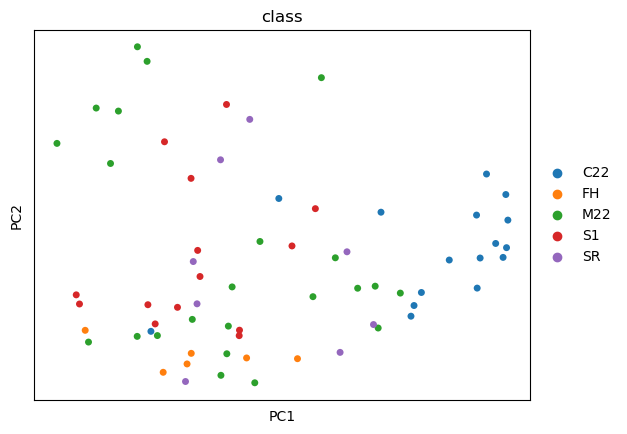

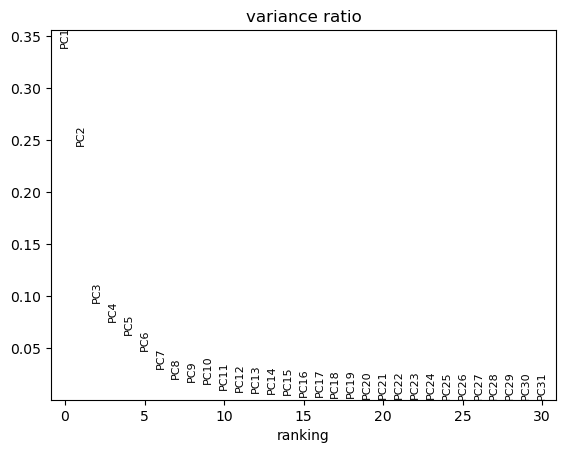

In [33]:
#PCA with scanpy
sc.tl.pca(adata)
sc.pl.pca(adata,color='class',size=100)
sc.pl.pca_variance_ratio(adata, log=False,)

explained_variance_ratio [0.33854484 0.24418495 0.09330581]


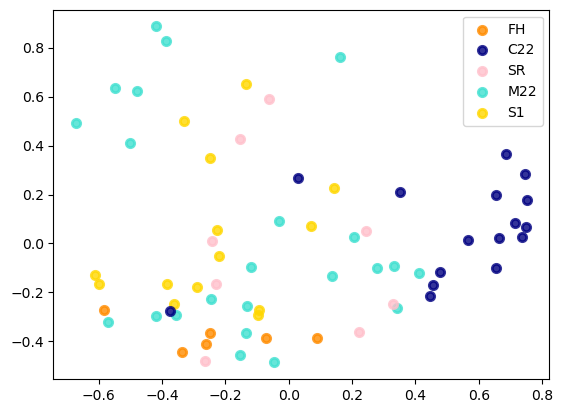

In [23]:
#sanity check with sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(train_styles)
X=pca.transform(train_styles)
print('explained_variance_ratio',pca.explained_variance_ratio_)

colors = ["navy", "turquoise", "darkorange","pink","gold"]
target_names = ['C22','M22','FH','SR','S1']

lw = 2
for point in range(len(X)):
    if data_classes_train[point]=='C22':
        c=colors[0]
    elif data_classes_train[point]=='M22':
        c=colors[1]
    elif data_classes_train[point]=='FH':
        c=colors[2]
    elif data_classes_train[point]=='SR':
        c=colors[3]
    elif data_classes_train[point]=='S1':
        c=colors[4]
    else:
        c='black'
    plt.scatter(X[point, 0], X[point, 1],color=c, alpha=.8, lw=lw,label=data_classes_train[point])

from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

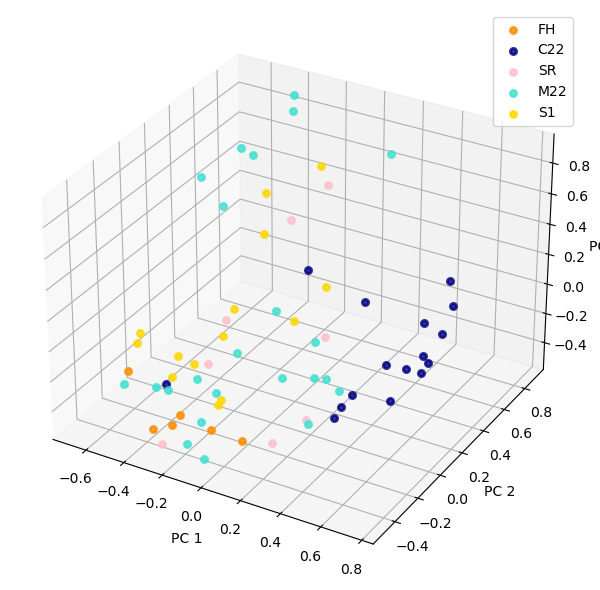

In [25]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

lw = 2
for point in range(len(X)):
    if data_classes_train[point]=='C22':
        c=colors[0]
    elif data_classes_train[point]=='M22':
        c=colors[1]
    elif data_classes_train[point]=='FH':
        c=colors[2]
    elif data_classes_train[point]=='SR':
        c=colors[3]
    elif data_classes_train[point]=='S1':
        c=colors[4]
    else:
        c='black'
    ax.scatter(X[point, 0], X[point, 1],X[point, 1],color=c, alpha=.8, lw=lw,label=data_classes_train[point])

from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.tight_layout();

In [35]:
#neighbourhoods
sc.pp.neighbors(adata, n_neighbors=34, n_pcs=2)

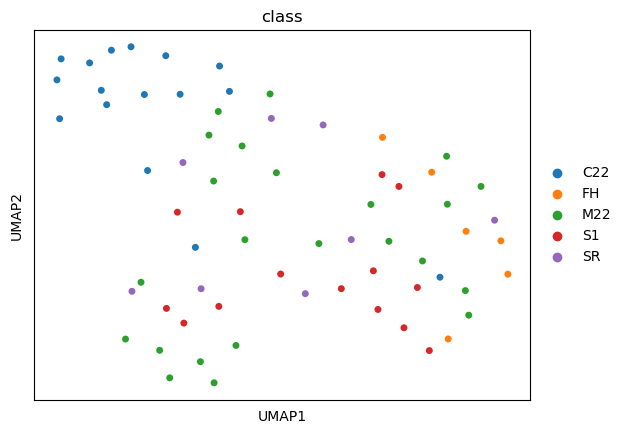

In [36]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='class', use_raw=False,size=100)

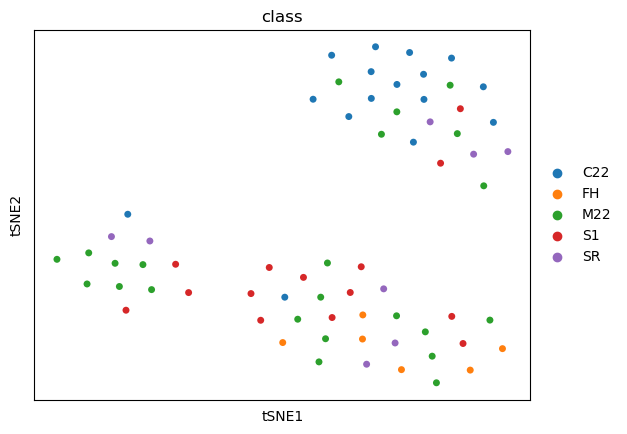

AnnData object with n_obs × n_vars = 67 × 256
    obs: 'class', 'leiden_gauss', 'leiden_umap', 'leiden_rapids'
    uns: 'pca', 'class_colors', 'neighbors', 'umap', 'tsne', 'gauss_neighbors', 'leiden', 'leiden_gauss_colors', 'umap_neighbors', 'leiden_umap_colors', 'rapids_neighbors', 'leiden_rapids_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'gauss_neighbors_distances', 'gauss_neighbors_connectivities', 'umap_neighbors_distances', 'umap_neighbors_connectivities', 'rapids_neighbors_distances', 'rapids_neighbors_connectivities'


In [188]:
sc.tl.tsne(adata, n_pcs=2,metric='cosine',random_state=42,perplexity=22) ## values taken from the cellpose 2.0 paper to reproduce clustering
sc.pl.tsne(adata,color='class',size=100)
print(adata)

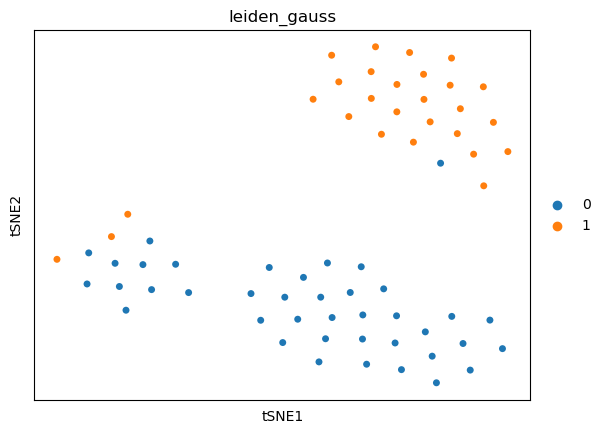

0    40
1    27
Name: leiden_gauss, dtype: int64


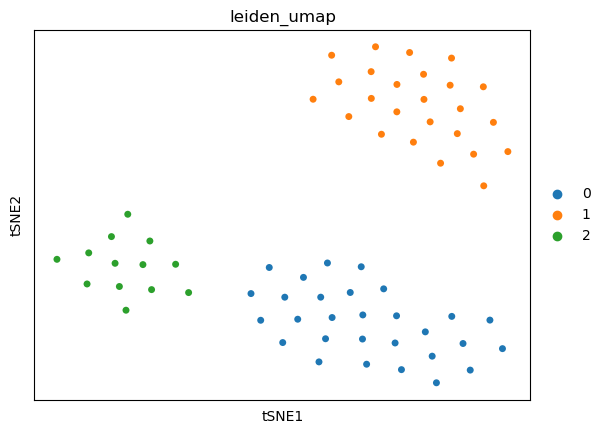

0    29
1    25
2    13
Name: leiden_umap, dtype: int64


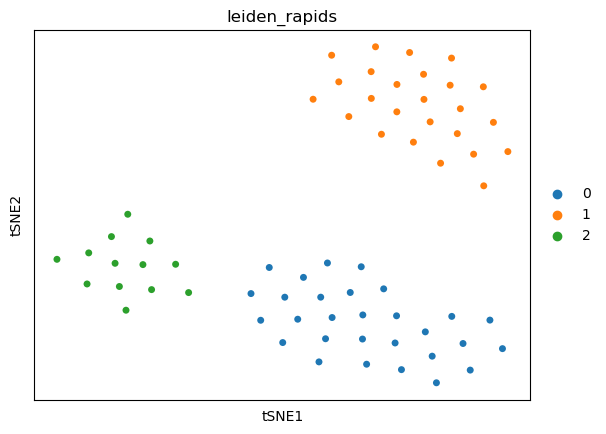

0    29
1    25
2    13
Name: leiden_rapids, dtype: int64


In [182]:
method_l = ['gauss','umap','rapids']
for k in range(3):
    #neighborhood graph https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.neighbors.html#scanpy-pp-neighbors
    sc.pp.neighbors(adata, n_neighbors=34, n_pcs=2,method=method_l[k],key_added=str(method_l[k])+'_neighbors')
    #clustering using the leiden algorithm https://scanpy.readthedocs.io/en/latest/generated/scanpy.tl.leiden.html#scanpy-tl-leiden
    sc.tl.leiden(adata, resolution=0.4, neighbors_key=str(method_l[k])+'_neighbors',key_added='leiden_'+str(method_l[k]))
    #plotting the clusters
    sc.pl.tsne(adata, color=['leiden_'+str(method_l[k])],size=100)
    print(adata.obs['leiden_'+str(method_l[k])].value_counts())

Using the code of Stringer & Pachitariu (2022) from 
https://github.com/MouseLand/cellpose/blob/main/paper/2.0/train_specialists.py

In [37]:
train_styles = np.array(train_styles)

In [38]:
from openTSNE import TSNE
from sklearn.decomposition import PCA

U = PCA(n_components=2).fit_transform(train_styles)
tsne = TSNE(
                perplexity=22,
                metric='cosine',
                n_jobs=8,
                random_state=42,
                verbose = True,
                n_components = 2,
                initialization = .0001 * U,
            )
embeddingOPENTSNE = tsne.fit(train_styles)

import scanpy as sc
adata = sc.AnnData(train_styles)
sc.pp.neighbors(adata, n_neighbors=34, use_rep='X')

sc.tl.leiden(adata, resolution=0.8)
leiden_labels = np.array(adata.obs['leiden'].astype(int))

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3).fit(train_styles, leiden_labels)
train_labels = classifier.predict(train_styles)
test_labels = classifier.predict(test_styles)

--------------------------------------------------------------------------------
TSNE(initialization=array([[-5.8256090e-05, -2.7168673e-05],
       [-2.4774112e-05, -3.6569174e-05],
       [-3.3635508e-05, -4.4310236e-05],
       [-7.3046735e-06, -3.8449798e-05],
       [ 8.7676181e-06, -3.8755148e-05],
       [-2.6096561e-05, -4.0900293e-05],
       [ 7.4765063e-05,  6.5874524e-06],
       [ 6.8444060e-05,  3.6662452e-05],
       [ 7.1337723e-05,  8.3035957e-06],
       [ 6.5298642e-05,  1.9893803e-05],
       [-2.2947508e...
       [ 7.4542622e-05,  2.8289805e-05],
       [ 4.4597284e-05, -2.1400978e-05],
       [ 7.3675154e-05,  2.6124701e-06],
       [ 4.7886828e-05, -1.1718395e-05],
       [ 6.5499036e-05, -9.9264980e-06],
       [ 3.5132245e-05,  2.1071564e-05],
       [ 2.8727929e-06,  2.6671993e-05],
       [-3.7504524e-05, -2.7582009e-05],
       [ 4.5560166e-05, -1.7040178e-05]], dtype=float32),
     metric='cosine', n_jobs=8, perplexity=22, random_state=42, verbose=True)
--

In [39]:
x=embeddingOPENTSNE[:,0]
y=embeddingOPENTSNE[:,1]

In [40]:
_, leiden_counts =np.unique(leiden_labels,return_counts=True)
_, knn_counts =np.unique(train_labels,return_counts=True)
print(leiden_counts,knn_counts)

[28 22 17] [29 22 16]


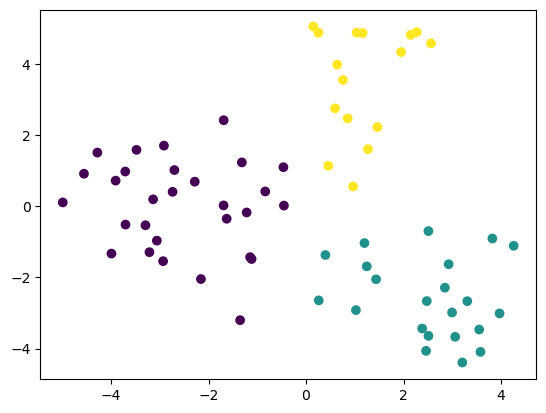

In [41]:
plt.scatter(x,y,c=train_labels);

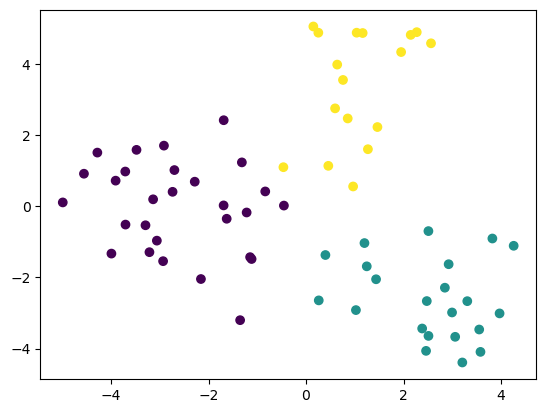

In [42]:
plt.scatter(x,y,c=leiden_labels);